In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report
import mat73

import sys
sys.path.append("..")
from hsvit.dataset import BrainTumorDataset
from hsvit.model import ViTBackbone
from hsvit.modules.token_filter import ProgressiveTokenFilter

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root_dir = "/Users/darshdave/Documents/BRAINTUMOR/DATASET/FILES/"
dataset = BrainTumorDataset(root_dir)
sample_loader = DataLoader(Subset(dataset, [0]), batch_size=1)


In [3]:
model = ViTBackbone().to(device)
model.eval()

ViTBackbone(
  (pre_encoder): PreEncoder(
    (conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 128, kernel_size=(16, 16), stride=(16, 16))
  )
  (transformer_blocks): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, e

In [4]:
token_filter = ProgressiveTokenFilter(keep_ratio=0.5)

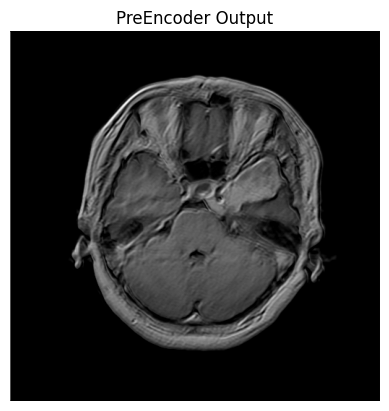

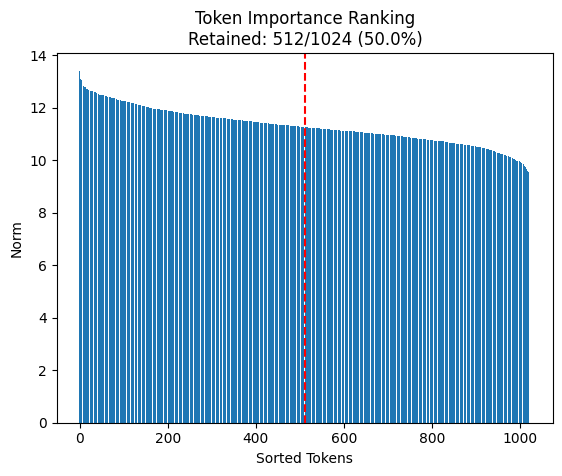

CLS Norm → Before TCM: 0.5797, After TCM: 0.6182


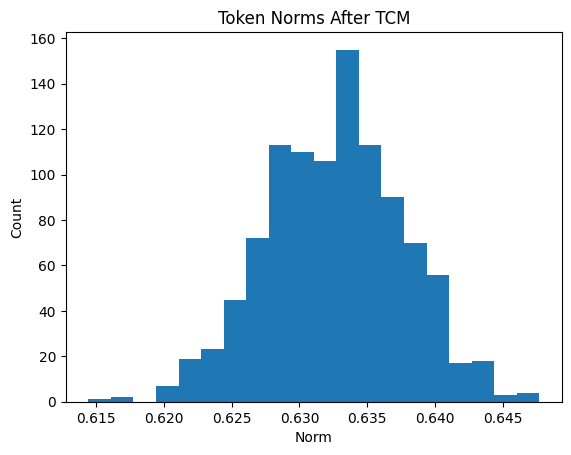

In [7]:
with torch.no_grad():
    for images, _ in sample_loader:
        images = images.to(device)

        # Stage 1: PreEncoder visualization
        pre_encoded = model.pre_encoder(images)
        plt.imshow(pre_encoded[0][0].cpu().numpy(), cmap='gray')
        plt.title("PreEncoder Output")
        plt.axis('off')
        plt.show()

        # Stage 2: PatchEmbedding
        x = model.patch_embed(pre_encoded)
        cls_token, patch_tokens = x[:, :1, :], x[:, 1:, :]

        norms = patch_tokens.norm(dim=-1).squeeze().cpu().numpy()
        if len(norms) == 196:
            plt.imshow(norms.reshape(14, 14), cmap='viridis')
            plt.title("Token Norms Heatmap (14×14)")
            plt.colorbar()
            plt.show()

        # Stage 3: Token Filtering Analysis
        token_filter = ProgressiveTokenFilter(keep_ratio=0.5)
        x_filtered = token_filter(x)
        retained = x_filtered.shape[1] - 1  # minus CLS
        total = patch_tokens.shape[1]

        plt.bar(range(len(norms)), np.sort(norms)[::-1])
        plt.axvline(retained, color='red', linestyle='--')
        plt.title(f"Token Importance Ranking\nRetained: {retained}/{total} ({retained/total*100:.1f}%)")
        plt.xlabel("Sorted Tokens")
        plt.ylabel("Norm")
        plt.show()

        # Stage 4: TCM - visualize effect on CLS token
        clar_output = model.clar([x for _ in range(4)])  # mimic fused output
        before_tcm = clar_output[:, 0, :]
        after_tcm = model.tcm(clar_output)[:, 0, :]

        norm_before = before_tcm.norm(dim=-1).item()
        norm_after = after_tcm.norm(dim=-1).item()
        print(f"CLS Norm → Before TCM: {norm_before:.4f}, After TCM: {norm_after:.4f}")

        # Optional: visualize token-wise norm distribution after TCM
        tcm_patch_tokens = model.tcm(clar_output)[:, 1:, :].squeeze()
        tcm_norms = tcm_patch_tokens.norm(dim=-1).cpu().numpy()
        plt.hist(tcm_norms, bins=20)
        plt.title("Token Norms After TCM")
        plt.xlabel("Norm")
        plt.ylabel("Count")
        plt.show()

        break

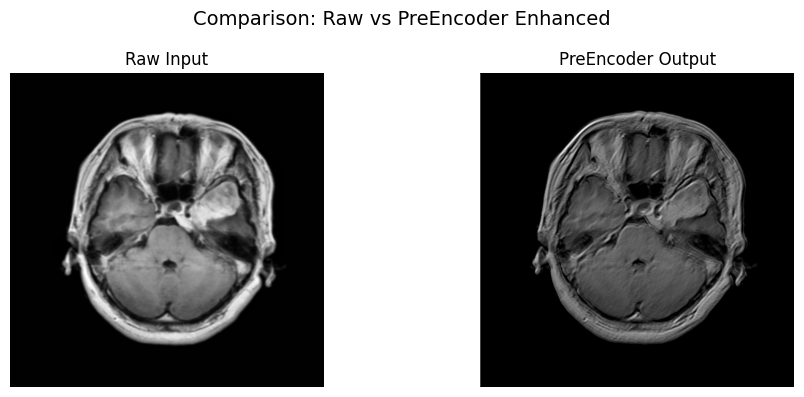

In [8]:
with torch.no_grad():
    for images, _ in sample_loader:
        images = images.to(device)

        # Get raw input image
        raw = images[0][0].cpu().numpy()

        # Run PreEncoder
        pre_encoded = model.pre_encoder(images)
        enhanced = pre_encoded[0][0].cpu().numpy()

        # Plot both side by side
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(raw, cmap='gray')
        axs[0].set_title("Raw Input")
        axs[0].axis('off')

        axs[1].imshow(enhanced, cmap='gray')
        axs[1].set_title("PreEncoder Output")
        axs[1].axis('off')

        plt.suptitle("Comparison: Raw vs PreEncoder Enhanced", fontsize=14)
        plt.tight_layout()
        plt.show()

        break
